In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

JAK_INHIBITORS = False

data_dir = "../data/12112025_IF_scan"
if_data_files = ["Cell.csv"]

columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]

column_to_stain = dict(zip(range(1,13), ["pSTAT"]*6 + ["tSTAT"] * 6))
column_to_stain = dict(zip(range(1,13), ["pSTAT"]*12))
#column_to_stain = dict(zip(range(1,13), ["Old"]*3 + ["New"]*9))

row_to_t_pts = {
	"A":0,
	"B":15,
	"C":20,
	"D":25,
	"E":40,
	"F":60,
	#"G":60,
	#"H":90
}	

column_to_patient = {
	1:28,
	2:28,
	3:28,
	4:905,
	5:905,
	6:905,
	7:905,
	8:64,
	9:64,
	10:64,
	11:64,
	#12:905
}

row_to_replicate = {
	"A":1,
	"B":2,
	"C":3,
	"D":1,
	"E":3,
	"F":1,
	#"G":2,
	#"H":1    
}

column_to_replicate = {
	1:1,
	2:2,
	3:3,
	4:1,
	5:2,
	6:3,
	7:4,
	8:1,
	9:2,
	10:3,
	11:4,
	#2:3
}


In [2]:
dfs = []
for fname in if_data_files:
	full_fname = f"{data_dir}/{fname}"
	df = pd.read_csv(full_fname, usecols=columns)

	stat1_means = df.groupby("WellId")["CircTotalIntenCh2"].mean()
	stat1_sems = df.groupby("WellId")["CircTotalIntenCh2"].std()
	stat3_means = df.groupby("WellId")["CircTotalIntenCh3"].mean()
	stat3_sems = df.groupby("WellId")["CircTotalIntenCh3"].std()

	stat_df = pd.concat([stat1_means, stat1_sems, stat3_means, stat3_sems], axis=1)
	stat_df.columns = ["STAT1 Mean", "STAT1 SEM", "STAT3 Mean", "STAT3 SEM"]
	stat_df.index = [x.strip() for x in stat_df.index]
	# Assign various characteristics based on wells using the dictionaries above
	rows = [x.strip()[0] for x in stat_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_df.index.values]
	stat_df["STAT"] = [column_to_stain[x] for x in cols]
	stat_df["PatientId"] = [column_to_patient[x] for x in cols]
	stat_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_df["Time"] = [row_to_t_pts[x] for x in rows]
	stat_df["Replicate"] = [column_to_replicate[x] for x in cols]
	stat_df["Date"] = data_dir.split("/")[-1]
 
	# REPLACE INFORMATION FOR SPECIAL WELLS THAT DO NOT MATCH DICTIONARY INFO ABOVE
	stat_df.loc["E01", "Time"] = 60
 
	display(stat_df)
	stat_df.to_csv(f"{data_dir.split('/')[-1]}.csv")
	dfs.append(stat_df)
 
patient_to_marker = {
	617:"s",
	626:"*",
	813:"v",
	826:"X",
	904:"P",
	905:"o",
	28:"^",
	64:"D"
}


,STAT1 Mean,STAT1 SEM,STAT3 Mean,STAT3 SEM,STAT,PatientId,IL-6 Concentration,Time,Replicate,Date
A01,9.722443e+05,3.028518e+05,8.891679e+05,2.934838e+05,pSTAT,28,10 ng/mL,0,1,12112025_IF_scan
A02,1.262701e+06,1.577460e+06,1.074056e+06,1.242623e+06,pSTAT,28,10 ng/mL,0,2,12112025_IF_scan
A03,1.106174e+06,4.266389e+05,1.093250e+06,6.713640e+05,pSTAT,28,10 ng/mL,0,3,12112025_IF_scan
A04,1.252108e+06,4.123310e+05,1.159784e+06,3.821175e+05,pSTAT,905,10 ng/mL,0,1,12112025_IF_scan
A05,1.207792e+06,3.239740e+05,1.140056e+06,3.354371e+05,pSTAT,905,10 ng/mL,0,2,12112025_IF_scan
...,...,...,...,...,...,...,...,...,...,...
F07,1.263580e+06,3.414131e+05,1.802719e+06,6.285577e+05,pSTAT,905,10 ng/mL,60,4,12112025_IF_scan
F08,1.194556e+06,7.240737e+05,1.306559e+06,4.913158e+05,pSTAT,64,10 ng/mL,60,1,12112025_IF_scan
F09,1.090871e+06,4.631662e+05,1.189897e+06,3.671587e+05,pSTAT,64,10 ng/mL,60,2,12112025_IF_scan
F10,1.120055e+06,7.123450e+05,1.247724e+06,4.456483e+05,pSTAT,64,10 ng/mL,60,3,12112025_IF_scan


(2,)


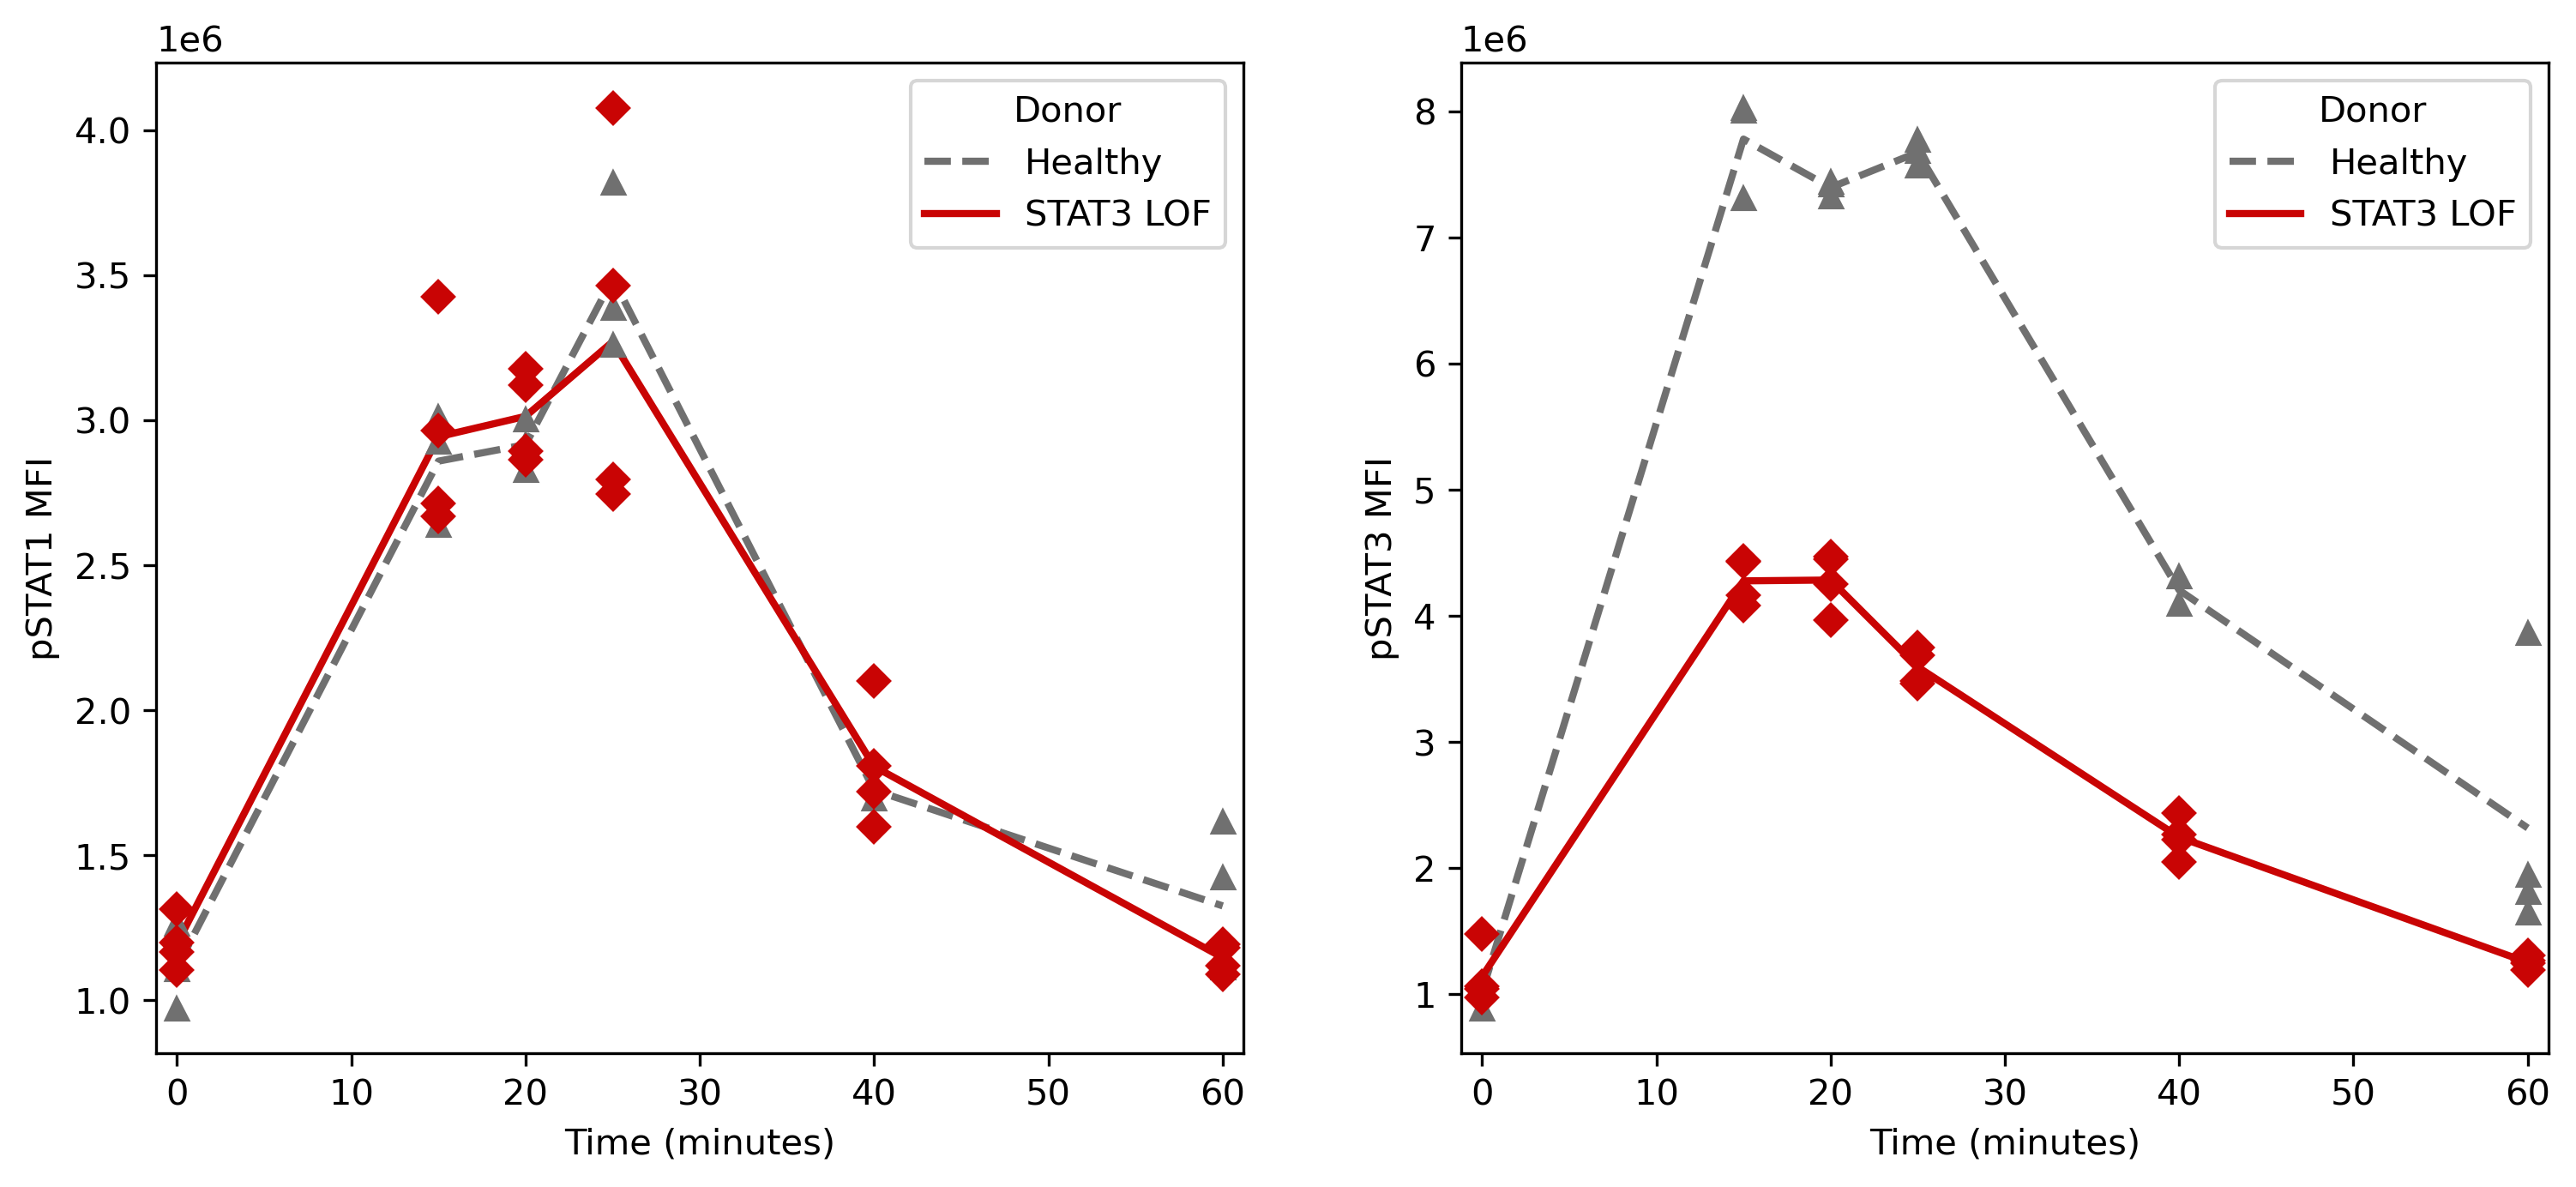

In [8]:
patient_to_color = {
	617: "r",
	626: "darkblue",
	813: "g",
	826: "orange",
	904: "purple",
	905: "deepskyblue",
	28: "#707070",
	64: "#C90404"
}

df = dfs[0]
ms = 6 # markersize
fig1, axs = plt.subplots(1,2, figsize=(12,5), dpi=300)
print(axs.shape)
df["STAT1 SEM"] = [0] * len(df)
df["STAT3 SEM"] = [0] * len(df)
# Select tSTAT measurement

for pat in df["PatientId"].unique():
	if pat == 905:# or pat == 905:
		continue;
	# Plot tSTATs from first scan
	stat1_ax = axs[0]
	stat3_ax = axs[1]
 
	cur_df = df.loc[df["PatientId"] == pat]

	leg_label = {
		28:"Healthy",
		64:"STAT3 LOF"
	}
	ls="--"
	if pat == 64:
		ls="-"
	#stat1_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT1 Mean"].mean(),
	#				marker="none", color=patient_to_color[pat], 
	# 				lw=2, label=f"{pat}")#) Average")
	sns.lineplot(x="Time", y="STAT1 Mean", data=cur_df,	color=patient_to_color[pat], 
	 				lw=2, label=f"{leg_label[pat]}", ax=stat1_ax, errorbar=None, ls=ls)
	sns.lineplot(x="Time", y="STAT3 Mean", data=cur_df,	color=patient_to_color[pat], 
	 				lw=2, label=f"{leg_label[pat]}", ax=stat3_ax, errorbar=None, ls=ls)
 
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		#if 0 == 0:
		#	continue; 
		if select_df.empty:
			continue
		fc=None
		markeredgecolor=None
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none",)
#	 				lw=0.75, label=f"{pat} - {rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none",) 
	 				#lw=0.75,  label=f"{pat} - {rep}", capsize=2)
	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.margins(x=0.02)
	stat3_ax.margins(x=0.02);
	stat1_ax.set_xlabel("Time (minutes)")
	stat1_ax.legend(title="Donor")
	#stat1_ax.set_title("Fedratinib")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Time (minutes)")
	stat3_ax.legend(title="Donor")
	#stat3_ax.set_title("Fedratinib")
	#stat1_ax.set_xlim(right=62)
	#stat3_ax.set_xlim(right=62)